# Expérience — Encoder refit sur données bruitées (extension de “Refit Your Encoder”)

Ici, on veut tester l’idée de **refit de l’encodeur** : on garde le décodeur $p_\theta(x|z)$ **figé** et on ré-optimise seulement l’encodeur $q_\phi(z|x)$ sur un nouveau dataset.  
Le but est de voir si on peut **réduire l’amortization gap** quand les données de test sont “différentes” (ici : images MNIST corrompues).

**1) Création des datasets bruités.**  
On part de MNIST binarisé, puis on construit des versions corrompues en *flipant* $n$ pixels aléatoires par image :
$$
x'_j =
\begin{cases}
1-x_j & \text{si } j \in S,\ |S|=n \\
x_j & \text{sinon}
\end{cases}
$$
On teste trois niveaux de bruit : $n \in \{10, 50, 100\}$.

**2) Deux ensembles pour séparer “apprentissage” et “généralisation”.**  
Pour un niveau de bruit donné, on définit :
- **A** = ensemble sur lequel on fait le refit (ici `valid_corrupted`),
- **B** = ensemble indépendant pour vérifier si ça généralise (ici `test_corrupted`).

**3) Refit = on entraîne uniquement l’encodeur.**  
On charge un modèle déjà entraîné (encodeur + décodeur), puis on fige le décodeur.  
On fait ensuite quelques epochs de gradient descent sur l’encodeur en maximisant l’ELBO (donc en minimisant $-\mathcal L[q_\phi]$).

**4) Mesure pendant le refit : IWAE sur A et B.**  
Toutes les quelques epochs, on suit l’estimation IWAE :
$$
\log \hat p(x) = \log\left(\frac{1}{K}\sum_{k=1}^K \frac{p_\theta(x,z_k)}{q_\phi(z_k|x)}\right), \quad z_k \sim q_\phi(z|x).
$$
On trace IWAE(A) et IWAE(B) au cours du refit.

**Ce qu’on regarde sur les courbes.**
- Si **IWAE(A) et IWAE(B) montent au début**, ça veut dire que le refit aide vraiment l’inférence (meilleure adaptation à la distribution bruitée).  
- Si ensuite **IWAE(A) continue à monter mais IWAE(B) plafonne**, on voit un effet “overfit” : l’encodeur s’adapte trop aux exemples de A.  
- En comparant $10/50/100$ pixels, on voit comment le niveau de bruit change l’équilibre entre adaptation utile et sur-apprentissage.

## imports and tools

In [7]:
import os, sys, numpy as np, time, math
from pathlib import Path
import torch, torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
import matplotlib.pyplot as plt
import csv

base_dir = Path.cwd().parent
sys.path.insert(0, str(base_dir / 'models'))
sys.path.insert(0, str(base_dir / 'models' / 'utils'))


from vae_2 import VAE
from inference_net import standard
from distributions import Gaussian
from optimize_local_q import optimize_local_q_dist


device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(f'device: {device}')

device: mps


In [ ]:
def build_model(q_class, x_size=2, z_size=50, hnf_flag=False):
    enc_arch = [[x_size,200],[200,200],[200,2*z_size]] if q_class is Gaussian else [[x_size,100],[100,2*z_size]]
    hyper = {
        'x_size': x_size, 'z_size': z_size, 'act_func': F.tanh,
        'encoder_arch': enc_arch,
        'decoder_arch': [[z_size,200],[200,200],[200,x_size]],
        'q_dist': standard, 'cuda': int(device.type=='cuda'),
        'hnf': int(hnf_flag)
    }
    q = q_class(hyper)
    hyper['q'] = q
    m = VAE(hyper).to(device)
    m.hyper_params = hyper
    return m, hyper


def save_weights(model, tag, out_dir):
    enc_p = out_dir / f"encoder_{tag}.pt"
    dec_p = out_dir / f"decoder_{tag}.pt"
    torch.save(model.q_dist.state_dict(), enc_p)
    torch.save(model.generator.state_dict(), dec_p)
    return enc_p, dec_p

def load_weights(model, enc_p, dec_p):
    model.q_dist.load_state_dict(torch.load(enc_p, map_location=device))
    model.generator.load_state_dict(torch.load(dec_p, map_location=device))
    model.eval()
    print(f"🔁 Modèle chargé : {enc_p.name}, {dec_p.name}")


def train_step(model, X, opt, warmup_T=50.0, total_epochs=0, batch_size=64):
    X_t = torch.from_numpy(X).float()
    y = torch.zeros(len(X))
    loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_t, y), batch_size=batch_size, shuffle=True)
    
    grad_norms_enc = []
    grad_norms_dec = []
    
    for xb, _ in loader:
        xb = xb.to(device)
        opt.zero_grad()
        warm = min(total_epochs / warmup_T, 1.0)
        elbo, _, _ = model.forward(xb, k=1, warmup=warm)
        
        ## calcul des normes des gradients
        enc_params = [p for p in model.q_dist.parameters() if p.grad is not None]
        #print(p.grad for p in enc_params)
        enc_norm = np.sqrt(sum(torch.sum(p.grad ** 2) for p in enc_params))

        dec_params = [p for p in model.generator.parameters() if p.grad is not None]
        dec_norm = np.sqrt(sum(torch.sum(p.grad ** 2) for p in dec_params))

        (-elbo).backward()
        opt.step()
        grad_norms_enc.append(enc_norm.item())
        grad_norms_dec.append(dec_norm.item())

    mean_enc_grad = np.mean(grad_norms_enc)
    mean_dec_grad = np.mean(grad_norms_dec)
    return elbo.item(), mean_enc_grad, mean_dec_grad


@torch.no_grad()
def amortized_elbo(model, X, k=1, batch_size=100):
    vals = []
    loader = torch.utils.data.DataLoader(torch.from_numpy(X).float(), batch_size=batch_size, shuffle=False)
    for xb in loader:
        xb = xb.to(device)
        elbo, _, _ = model.forward(xb, k=k, warmup=1.0)
        vals.append(elbo.item())
    return float(np.mean(vals))

def locally_optimized_elbo(model, X, n_points=10):
    vals = []
    for i in range(min(n_points, len(X))):
        x = torch.from_numpy(X[i]).float().view(1,-1).to(device)
        logpost = lambda z: model.logposterior_func2(x=x, z=z)
        if isinstance(model.q_dist, Gaussian):
            q_local = Gaussian(model.hyper_params).to(device)
        elif isinstance(model.q_dist, Flow1):
            q_local = Flow1(model.hyper_params).to(device)
        elif isinstance(model.q_dist, HNF):
            q_local = HNF(model.hyper_params).to(device)
        else:
            raise ValueError(f"Famille q_dist inconnue : {type(model.q_dist)}")
        vae_star, _ = optimize_local_q_dist(logpost, model.hyper_params, x, q_local)
        vals.append(float(vae_star.item()))
    return float(np.mean(vals))

@torch.no_grad()
def logp_iwae(model, X, K=500, batch_size=100):
    vals = []
    loader = torch.utils.data.DataLoader(torch.from_numpy(X).float(), batch_size=batch_size, shuffle=False)
    for xb in loader:
        xb = xb.to(device)
        iwaeK, _, _ = model.forward2(xb, k=K)
        vals.append(iwaeK.item())
    return float(np.mean(vals))


## load data / models

### load and corrupt data

In [ ]:
import torch
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from vae_2 import VAE
from distributions import Gaussian
from inference_net import standard
from optimize_local_q import optimize_local_q_dist

device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')

npz_path = 'C:\\Users\\titou\\OneDrive\\Bureau\\mva\\vae\\papier code\\Inference-Suboptimality\\binarized_mnist.npz'
data = np.load(npz_path)


train_x = data['train_data']
valid_x = data['valid_data']
test_x  = data['test_data']

def corrupt_pixels(X, n_pixels=10):
    Xc = X.copy()
    n, d = X.shape
    for i in range(n):
        idx = np.random.choice(d, n_pixels, replace=False)
        Xc[i, idx] = 1 - Xc[i, idx]  # flip de pixels
    return Xc

# Différents types de corruptions
test_corrupted1 = corrupt_pixels(test_x, n_pixels=10)
test_corrupted2 = corrupt_pixels(test_x, n_pixels=50)
test_corrupted3 = corrupt_pixels(test_x, n_pixels=100)

valid_corrupted1 = corrupt_pixels(valid_x, n_pixels=10)
valid_corrupted2 = corrupt_pixels(valid_x, n_pixels=50)
valid_corrupted3 = corrupt_pixels(valid_x, n_pixels=100)


✅ Device: cpu


C:\Users\titou\AppData\Local\Temp\ipykernel_33908\3945333978.py:25: UserWarning: Reading `.npy` or `.npz` file required additional header parsing as it was created on Python 2. Save the file again to speed up loading and avoid this warning.
  train_x = data['train_data']
C:\Users\titou\AppData\Local\Temp\ipykernel_33908\3945333978.py:26: UserWarning: Reading `.npy` or `.npz` file required additional header parsing as it was created on Python 2. Save the file again to speed up loading and avoid this warning.
  valid_x = data['valid_data']
C:\Users\titou\AppData\Local\Temp\ipykernel_33908\3945333978.py:27: UserWarning: Reading `.npy` or `.npz` file required additional header parsing as it was created on Python 2. Save the file again to speed up loading and avoid this warning.
  test_x  = data['test_data']


### load model

In [31]:
encoder_path = Path(r"C:\Users\titou\OneDrive\Bureau\mva\vae\papier code\Inference-Suboptimality\exp55_checkpoints\encoder_Gaussian_ep400.pt")
decoder_path = Path(r"C:\Users\titou\OneDrive\Bureau\mva\vae\papier code\Inference-Suboptimality\exp55_checkpoints\decoder_Gaussian_ep400.pt")
print(test_x.shape[1])
model, _ = build_model(Gaussian, x_size=test_x.shape[1])
load_weights(model, encoder_path, decoder_path)

784
🔁 Modèle chargé : encoder_Gaussian_ep400.pt, decoder_Gaussian_ep400.pt


### refit encoder fonction

In [ ]:
def refit_encoder(model, val_corrupted, test_corrupted, n_epochs=10, lr=1e-4, batch_size=64, K_eval=50):
    """
    Réentraîne uniquement l'encodeur sur un jeu de données donné (X_refit).
    Évalue la log-vraisemblance IWAE avant, pendant et après le refit
    sur les ensembles A (refit) et B (éval indépendante).
    """
    device = next(model.parameters()).device
    opt_enc = optim.Adam(model.q_dist.parameters(), lr=lr)
    X_t = torch.from_numpy(val_corrupted).float()
    X_eval_t = torch.from_numpy(test_corrupted).float()

    # DataLoader pour le refit 
    y = torch.zeros(len(val_corrupted))
    loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_t, y),
                                         batch_size=batch_size, shuffle=True)
    
    # Logs pour suivi
    iwae_refitA = []
    iwae_evalB = []

    print("➡️ Évaluation avant refit...")
    iwae_refitA.append(logp_iwae(model, val_corrupted, K=K_eval))
    iwae_evalB.append(logp_iwae(model, test_corrupted, K=K_eval))
    print(f"Avant refit: IWAE(A)={iwae_refitA[-1]:.4f}, IWAE(B)={iwae_evalB[-1]:.4f}\n")

    # Refit de l'encodeur
    model.train()
    for ep in range(n_epochs):
        for xb, _ in loader:
            xb = xb.to(device)
            opt_enc.zero_grad()
            elbo, _, _ = model.forward(xb, k=1, warmup=1.0)
            (-elbo).backward()
            opt_enc.step()

        if (ep + 1) % 5 == 0 or ep == n_epochs - 1:
            model.eval()
            iwae_a = logp_iwae(model, val_corrupted, K=K_eval)
            iwae_b = logp_iwae(model, test_corrupted, K=K_eval)
            iwae_refitA.append(iwae_a)
            iwae_evalB.append(iwae_b)
            print(f"[Epoch {ep+1}] IWAE(A)={iwae_a:.4f}, IWAE(B)={iwae_b:.4f}")
            model.train()

    model.eval()
    print(f"Encoder refitted ({n_epochs} epochs)")
    
    # Tracé du graphe
    epochs = [0] + [5 * i for i in range(1, len(iwae_refitA))]  # epochs évalués
    plt.figure(figsize=(6,4))
    plt.plot(epochs, iwae_refitA, label="test A (refit)")
    plt.plot(epochs, iwae_evalB, label="test B (independant)")
    plt.xlabel("Epochs")
    plt.ylabel("IWAE log-likelihood")
    plt.title("IWAE during encoder refit")
    plt.legend()
    plt.grid(True)
    plt.show()


    return iwae_refitA, iwae_evalB


## Exp 8

### Corrupted 10 pixels

🔁 Modèle chargé : encoder_Gaussian_ep400.pt, decoder_Gaussian_ep400.pt


➡️ Évaluation avant refit...
Avant refit: IWAE(A)=-244.7822, IWAE(B)=-243.7293

[Epoch 5] IWAE(A)=-238.4723, IWAE(B)=-238.2760
[Epoch 10] IWAE(A)=-237.1573, IWAE(B)=-237.5141
[Epoch 15] IWAE(A)=-236.3506, IWAE(B)=-237.0812
[Epoch 20] IWAE(A)=-235.7032, IWAE(B)=-236.7069
[Epoch 25] IWAE(A)=-235.2165, IWAE(B)=-236.4395
[Epoch 30] IWAE(A)=-234.7137, IWAE(B)=-236.2501
[Epoch 35] IWAE(A)=-234.4100, IWAE(B)=-236.0803
[Epoch 40] IWAE(A)=-234.1575, IWAE(B)=-236.0225
[Epoch 45] IWAE(A)=-233.8335, IWAE(B)=-235.8366
[Epoch 50] IWAE(A)=-233.6310, IWAE(B)=-235.8247
[Epoch 55] IWAE(A)=-233.2992, IWAE(B)=-235.6234
[Epoch 60] IWAE(A)=-233.1606, IWAE(B)=-235.6504
[Epoch 65] IWAE(A)=-232.9431, IWAE(B)=-235.5835
[Epoch 70] IWAE(A)=-232.7799, IWAE(B)=-235.4877
[Epoch 75] IWAE(A)=-232.6052, IWAE(B)=-235.4733
[Epoch 80] IWAE(A)=-232.4747, IWAE(B)=-235.4580
[Epoch 85] IWAE(A)=-232.3646, IWAE(B)=-235.4443
[Epoch 90] IWAE(A)=-232.2136, IWAE(B)=-235.4774
[Epoch 95] IWAE(A)=-232.0985, IWAE(B)=-235.3857
[Epoch 1

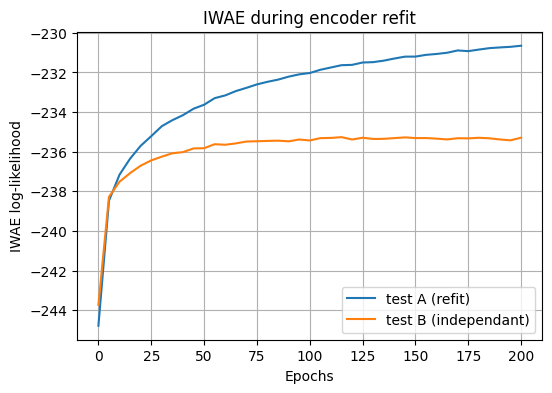

In [44]:
model, _ = build_model(Gaussian, x_size=test_x.shape[1])
load_weights(model, encoder_path, decoder_path)
iwae_A, iwae_B = refit_encoder(model, valid_corrupted1, test_corrupted1, n_epochs=200, lr=1e-4, K_eval=50)

### Corrupted avec 50 pixels

🔁 Modèle chargé : encoder_Gaussian_ep400.pt, decoder_Gaussian_ep400.pt
➡️ Évaluation avant refit...
Avant refit: IWAE(A)=-820.0109, IWAE(B)=-820.1327

[Epoch 5] IWAE(A)=-775.1721, IWAE(B)=-778.5208
[Epoch 10] IWAE(A)=-765.4638, IWAE(B)=-771.3873
[Epoch 15] IWAE(A)=-759.0345, IWAE(B)=-766.8236
[Epoch 20] IWAE(A)=-754.5488, IWAE(B)=-763.9365
[Epoch 25] IWAE(A)=-750.9533, IWAE(B)=-761.9486
[Epoch 30] IWAE(A)=-747.9139, IWAE(B)=-760.2530
[Epoch 35] IWAE(A)=-745.2687, IWAE(B)=-758.9170
[Epoch 40] IWAE(A)=-743.4128, IWAE(B)=-758.3108
[Epoch 45] IWAE(A)=-741.3697, IWAE(B)=-757.4786
[Epoch 50] IWAE(A)=-739.4670, IWAE(B)=-756.9454
[Epoch 55] IWAE(A)=-738.0020, IWAE(B)=-756.5432
[Epoch 60] IWAE(A)=-736.6952, IWAE(B)=-756.2671
[Epoch 65] IWAE(A)=-735.3679, IWAE(B)=-755.9111
[Epoch 70] IWAE(A)=-734.0702, IWAE(B)=-755.7096
[Epoch 75] IWAE(A)=-732.8863, IWAE(B)=-755.4304
[Epoch 80] IWAE(A)=-731.8476, IWAE(B)=-755.4213
[Epoch 85] IWAE(A)=-731.0890, IWAE(B)=-755.6007
[Epoch 90] IWAE(A)=-730.0789, IWAE

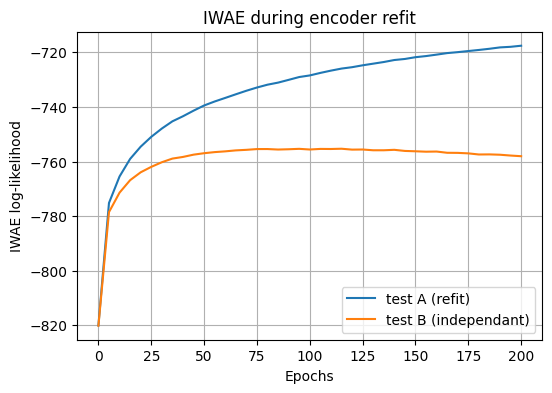

In [42]:
model, _ = build_model(Gaussian, x_size=test_x.shape[1])
load_weights(model, encoder_path, decoder_path)
iwae_A, iwae_B = refit_encoder(model, valid_corrupted2, test_corrupted2, n_epochs=200, lr=1e-4, K_eval=50)

### Corrupted avec 100 pixels

🔁 Modèle chargé : encoder_Gaussian_ep400.pt, decoder_Gaussian_ep400.pt
➡️ Évaluation avant refit...
Avant refit: IWAE(A)=-1484.5763, IWAE(B)=-1484.5533

[Epoch 5] IWAE(A)=-1238.5615, IWAE(B)=-1242.1220
[Epoch 10] IWAE(A)=-1230.9002, IWAE(B)=-1235.0330
[Epoch 15] IWAE(A)=-1225.9320, IWAE(B)=-1230.5730
[Epoch 20] IWAE(A)=-1221.8369, IWAE(B)=-1227.1517
[Epoch 25] IWAE(A)=-1218.5453, IWAE(B)=-1224.5569
[Epoch 30] IWAE(A)=-1215.9117, IWAE(B)=-1222.4601
[Epoch 35] IWAE(A)=-1213.6196, IWAE(B)=-1220.8436
[Epoch 40] IWAE(A)=-1211.4645, IWAE(B)=-1219.3254
[Epoch 45] IWAE(A)=-1209.4793, IWAE(B)=-1218.0799
[Epoch 50] IWAE(A)=-1207.6955, IWAE(B)=-1217.0523
[Epoch 55] IWAE(A)=-1205.9171, IWAE(B)=-1215.9164
[Epoch 60] IWAE(A)=-1204.4431, IWAE(B)=-1215.1908
[Epoch 65] IWAE(A)=-1203.1474, IWAE(B)=-1214.6696
[Epoch 70] IWAE(A)=-1201.8750, IWAE(B)=-1213.9520
[Epoch 75] IWAE(A)=-1200.7246, IWAE(B)=-1213.5543
[Epoch 80] IWAE(A)=-1199.6781, IWAE(B)=-1212.9987
[Epoch 85] IWAE(A)=-1198.8044, IWAE(B)=-1212.742

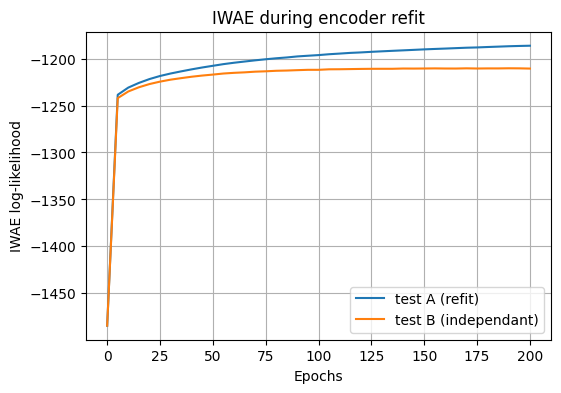

In [43]:
model, _ = build_model(Gaussian, x_size=test_x.shape[1])
load_weights(model, encoder_path, decoder_path)
iwae_A, iwae_B = refit_encoder(model, valid_corrupted3, test_corrupted3, n_epochs=200, lr=1e-4, K_eval=50)